In [1]:
import subprocess
import shlex
import re

import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")
TIMING_PATTERN = re.compile(r"\((\d+(?:\.\d+)?)s\)\.")

In [3]:
def test_exponential_inter_event_timing(
    mode, delta_t=1.0, lamda=0.5, seed=42, limit=1000000,
):
    output = subprocess.run(shlex.split(
        f"cargo run --release --quiet -- --delta-t {delta_t} --seed {seed} " +
        f"--lambda {lamda} --limit {limit} {CC_PATTERN.sub('-', mode).lower()}"
    ), check=True, capture_output=True, text=True).stdout
    
    return float(TIMING_PATTERN.search(output).group(1))

In [4]:
lambdas = [0.001, 0.002, 0.003, 0.006, 0.01, 0.02, 0.03, 0.06, 0.1, 0.18, 0.32, 0.56, 1.0, 1.8, 3.2, 5.6, 10.0, 18.0, 32.0, 56.0, 100.0]
modes = ["Exponential", "Poisson"]

exp_times = [test_exponential_inter_event_timing("Exponential", lamda=lamda) for lamda in lambdas]
poi_times = [test_exponential_inter_event_timing("Poisson", lamda=lamda) for lamda in lambdas]

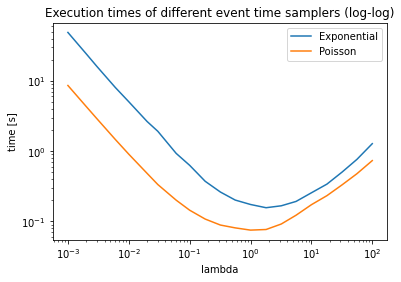

In [5]:
plt.title("Execution times of different event time samplers (log-log)")

plt.plot(lambdas, exp_times, label="Exponential")
plt.plot(lambdas, poi_times, label="Poisson")

plt.xlabel("lambda")
plt.ylabel("time [s]")

plt.xscale("log")
plt.yscale("log")
    
plt.legend()
plt.show()

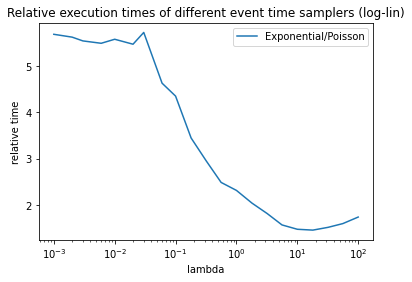

In [6]:
plt.title("Relative execution times of different event time samplers (log-lin)")

plt.plot(lambdas, [e / p for e, p in zip(exp_times, poi_times)], label="Exponential/Poisson")

plt.xlabel("lambda")
plt.ylabel("relative time")

plt.xscale("log")
    
plt.legend()
plt.show()